<a href="https://colab.research.google.com/github/mmcquade84/data-analysis/blob/main/Pricing_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install numpy pandas yfinance scipy matplotlib

<ipython-input-7-f46be6122153>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = ticker.history(period="1d")['Close'][-1]
<ipython-input-7-f46be6122153>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = ticker.history(period="1d")['Close'][-1]
<ipython-input-7-f46be6122153>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_price = ticker.history(period="1d")['Close'][-1]


Portfolio:
              Asset    Type  Quantity  Strike      Expiry       Price  \
0              AAPL   Stock   5000000     NaN        None  222.770004   
1              MSFT   Stock   3000000     NaN        None  409.440002   
2              GOOG   Stock   2000000     NaN        None  158.610001   
3  AAPL_CALL_OPTION  Option   1000000   150.0  2024-12-20   74.071589   

    Total Value  
0  1.113850e+09  
1  1.228320e+09  
2  3.172200e+08  
3  7.407159e+07  

Total Portfolio Value: $2733461618.45


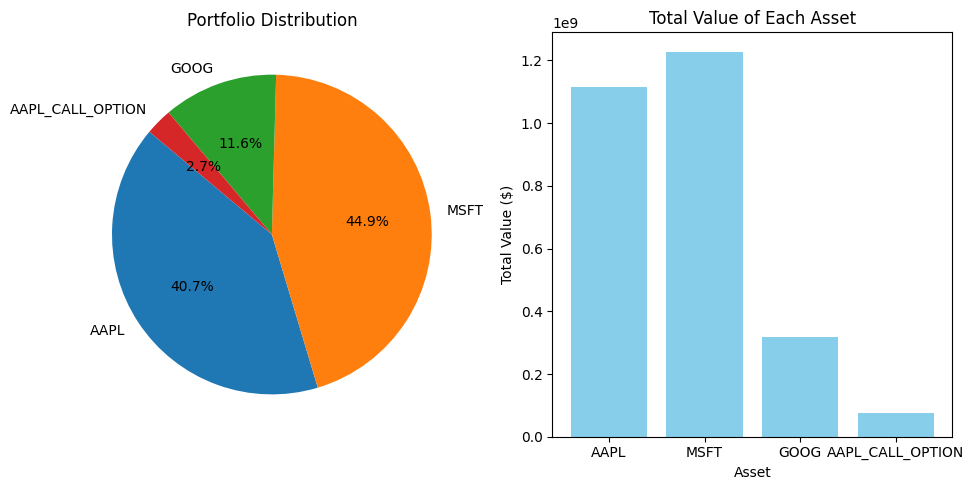

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

# Function to calculate Black-Scholes option price
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Example portfolio
# Increasing the quantity of each asset to have AUM > 10 billion
portfolio = pd.DataFrame({
    'Asset': ['AAPL', 'MSFT', 'GOOG', 'AAPL_CALL_OPTION'],
    'Type': ['Stock', 'Stock', 'Stock', 'Option'],
    'Quantity': [5000000, 3000000, 2000000, 1000000],  # Adjusted quantities to increase AUM
    'Strike': [None, None, None, 150],  # Strike price for the option
    'Expiry': [None, None, None, '2024-12-20']  # Expiry date for the option
})

# Fetch current stock prices with more reliable method
for asset in portfolio['Asset'].unique():
    if 'OPTION' not in asset:
        ticker = yf.Ticker(asset)
        try:
            # Use the most recent close price from the history method
            last_price = ticker.history(period="1d")['Close'][-1]
            portfolio.loc[portfolio['Asset'] == asset, 'Price'] = last_price
        except Exception as e:
            print(f"Warning: Could not fetch price for {asset}. Using fallback value. Error: {e}")
            portfolio.loc[portfolio['Asset'] == asset, 'Price'] = np.nan  # Fallback to NaN or any default

# Pricing options using Black-Scholes model
risk_free_rate = 0.03  # Example risk-free rate
volatility = 0.2  # Example volatility

current_date = datetime.now()
for i, row in portfolio.iterrows():
    if row['Type'] == 'Option':
        underlying_asset = row['Asset'].split('_')[0]
        S = portfolio.loc[portfolio['Asset'] == underlying_asset, 'Price'].values[0]
        if not np.isnan(S):  # Ensure S is a valid number
            K = row['Strike']
            expiry_date = datetime.strptime(row['Expiry'], '%Y-%m-%d')
            T = (expiry_date - current_date).days / 365.0  # Time to expiry in years
            option_price = black_scholes_call_price(S, K, T, risk_free_rate, volatility)
            portfolio.at[i, 'Price'] = option_price
        else:
            portfolio.at[i, 'Price'] = np.nan  # Set option price to NaN if underlying asset price is NaN

# Calculate total value of the portfolio
portfolio['Total Value'] = portfolio['Quantity'] * portfolio['Price']
total_portfolio_value = portfolio['Total Value'].sum()

print("Portfolio:")
print(portfolio)
print(f"\nTotal Portfolio Value: ${total_portfolio_value:.2f}")

# Check if there are valid values before plotting
if portfolio['Total Value'].isna().all():
    print("Error: All values in the portfolio are NaN. Unable to generate visualizations.")
else:
    # Visualization: Pie Chart for Portfolio Distribution
    plt.figure(figsize=(10, 5))

    # Pie chart for asset distribution
    plt.subplot(1, 2, 1)
    plt.pie(portfolio['Total Value'].fillna(0), labels=portfolio['Asset'], autopct='%1.1f%%', startangle=140)
    plt.title('Portfolio Distribution')

    # Bar chart for asset values
    plt.subplot(1, 2, 2)
    plt.bar(portfolio['Asset'], portfolio['Total Value'].fillna(0), color='skyblue')
    plt.xlabel('Asset')
    plt.ylabel('Total Value ($)')
    plt.title('Total Value of Each Asset')

    plt.tight_layout()
    plt.show()


In [8]:
pip install numpy pandas yfinance matplotlib scikit-learn

[*********************100%***********************]  1 of 1 completed


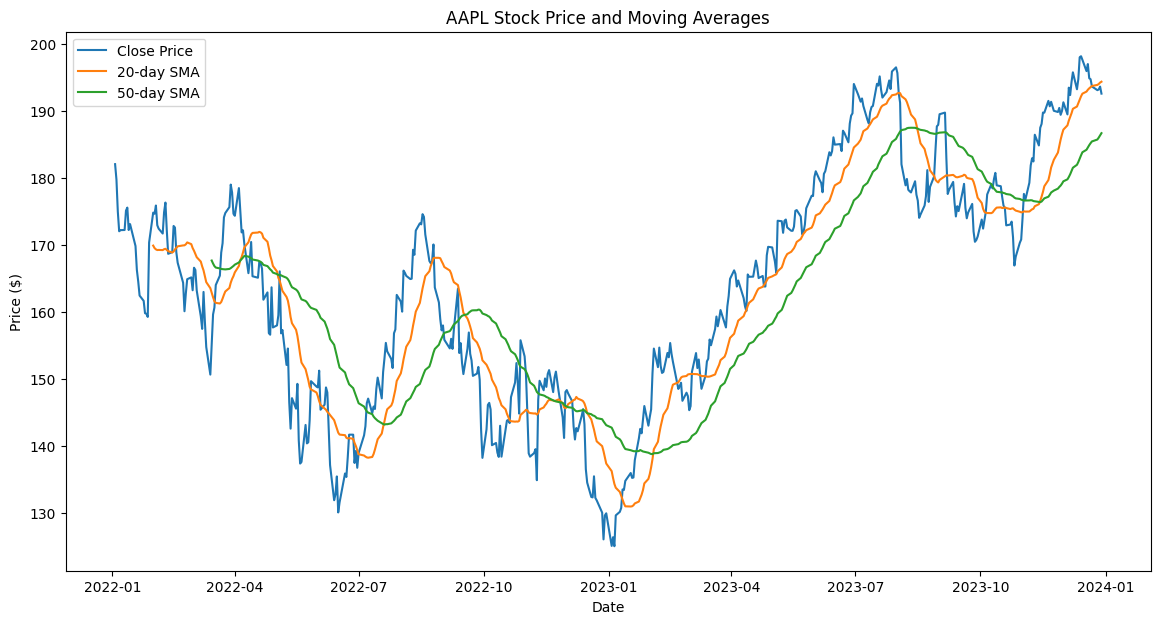

Mean Squared Error: 90.11110461303402


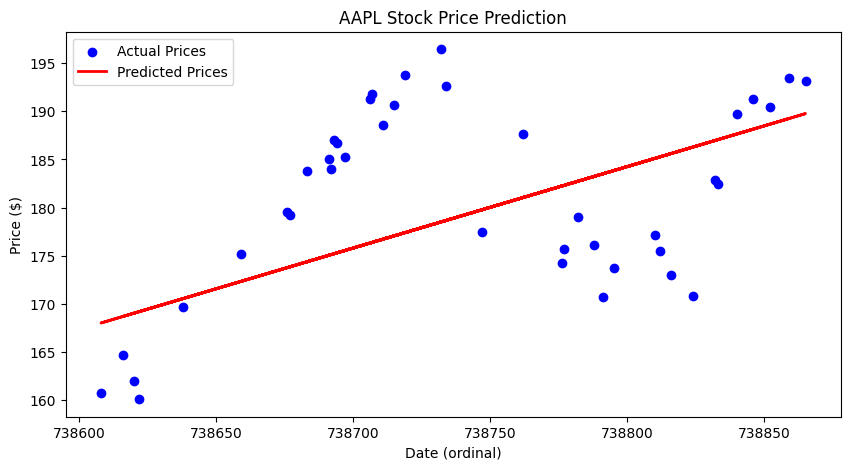

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the stock ticker and the time period for analysis
ticker = 'AAPL'
start_date = '2022-01-01'
end_date = '2024-01-01'

# Fetch historical data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate Moving Averages (e.g., 20-day and 50-day)
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()

# Plot the historical closing prices and moving averages
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(stock_data['SMA_20'], label='20-day SMA')
plt.plot(stock_data['SMA_50'], label='50-day SMA')
plt.title(f'{ticker} Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Prepare data for Linear Regression
stock_data['Date'] = pd.to_datetime(stock_data.index)
stock_data['Date'] = stock_data['Date'].map(datetime.toordinal)

# Use only the most recent 200 days for prediction
recent_data = stock_data.dropna().tail(200)
X = recent_data[['Date']]
y = recent_data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict using the model
y_pred = model.predict(X_test)

# Calculate and print the model's performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual Prices')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date (ordinal)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [10]:
pip install numpy pandas yfinance matplotlib

[*********************100%***********************]  4 of 4 completed


Portfolio Value at Risk (VaR) at 95.0% confidence level: 0.0000


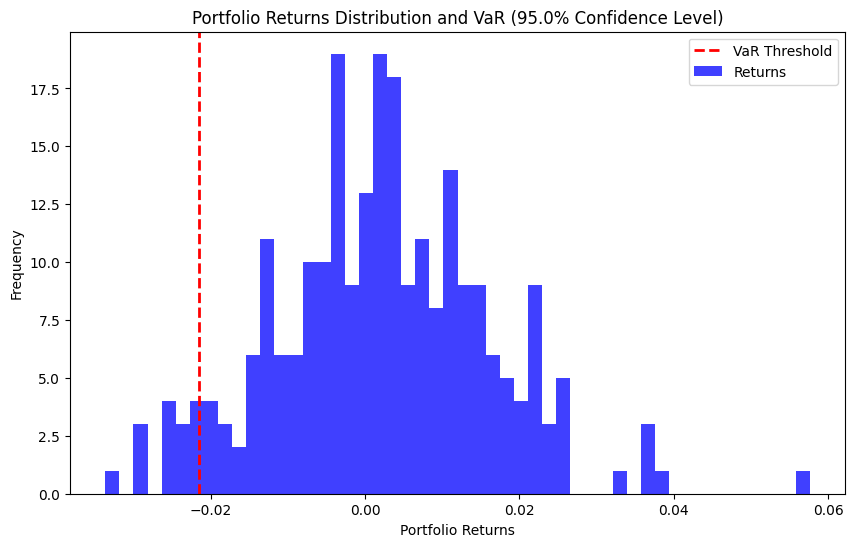

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define portfolio assets and weights
assets = ['AAPL', 'MSFT', 'GOOG', 'AMZN']
weights = np.array([0.25, 0.25, 0.25, 0.25])  # Equal weights for simplicity

# Define the time period for analysis
start_date = '2023-01-01'
end_date = '2024-01-01'

# Fetch historical data
data = yf.download(assets, start=start_date, end=end_date)['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Portfolio daily returns
portfolio_returns = returns.dot(weights)

# Historical VaR calculation
confidence_level = 0.95
var_percentile = 1 - confidence_level

# Calculate VaR at the given confidence level
VaR = np.percentile(portfolio_returns, var_percentile * 100)
VaR_value = VaR * portfolio_returns.mean() * -1  # Negative VaR to represent loss

print(f"Portfolio Value at Risk (VaR) at {confidence_level*100}% confidence level: {VaR_value:.4f}")

# Plot the distribution of portfolio returns and VaR
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.75, color='blue')
plt.axvline(VaR, color='red', linestyle='dashed', linewidth=2)
plt.title(f'Portfolio Returns Distribution and VaR ({confidence_level*100}% Confidence Level)')
plt.xlabel('Portfolio Returns')
plt.ylabel('Frequency')
plt.legend(['VaR Threshold', 'Returns'])
plt.show()

In [12]:
pip install numpy pandas matplotlib


Estimated European Call Option Price: $7.98


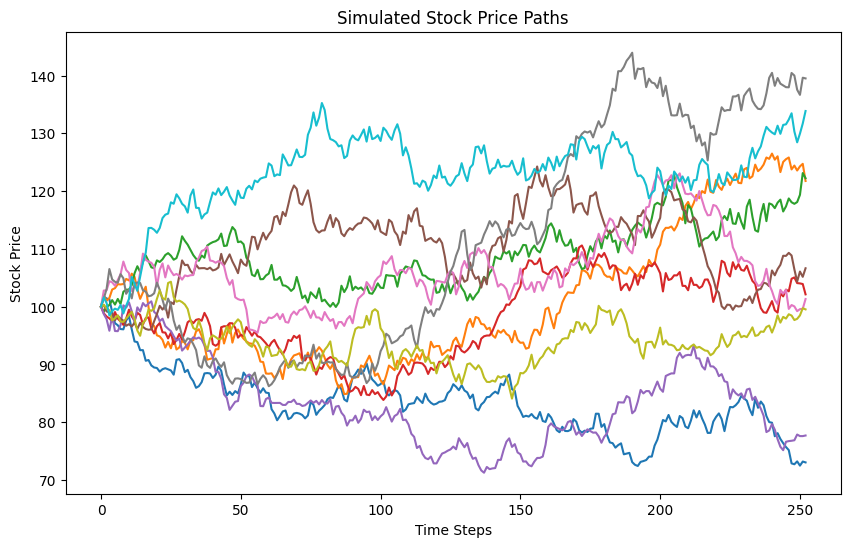

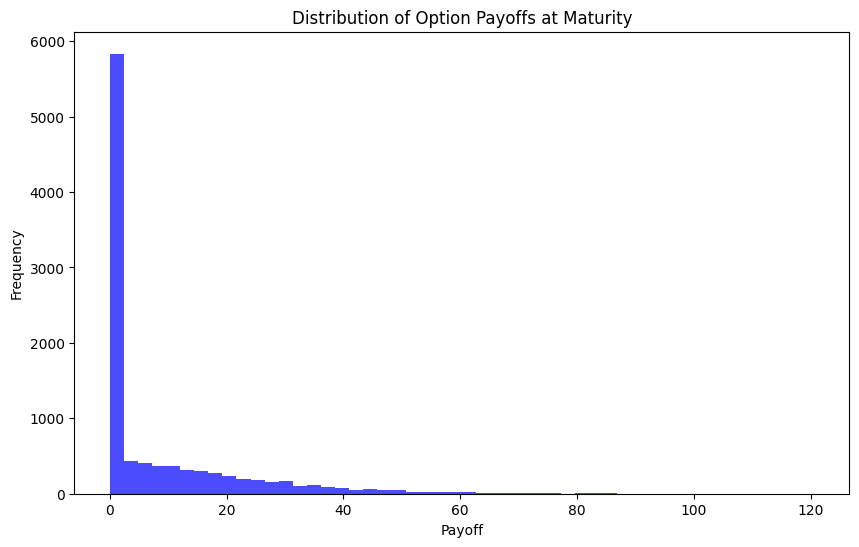

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the option and simulation
S0 = 100          # Initial stock price
K = 105           # Strike price
T = 1             # Time to maturity in years
r = 0.05          # Risk-free interest rate
sigma = 0.2       # Volatility of the stock
n_simulations = 10000  # Number of Monte Carlo simulations
n_steps = 252     # Number of time steps (trading days in a year)

# Function to simulate stock price paths
def simulate_stock_price(S0, r, sigma, T, n_steps, n_simulations):
    dt = T / n_steps
    price_paths = np.zeros((n_steps + 1, n_simulations))
    price_paths[0] = S0
    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_simulations)
        price_paths[t] = price_paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return price_paths

# Simulate stock price paths
price_paths = simulate_stock_price(S0, r, sigma, T, n_steps, n_simulations)

# Calculate the payoff for each simulation
payoffs = np.maximum(price_paths[-1] - K, 0)

# Discount back to present value
option_price = np.exp(-r * T) * np.mean(payoffs)

print(f"Estimated European Call Option Price: ${option_price:.2f}")

# Visualization: Plot a few simulated price paths
plt.figure(figsize=(10, 6))
plt.plot(price_paths[:, :10])  # Plotting first 10 simulations for clarity
plt.title('Simulated Stock Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

# Visualization: Histogram of option payoffs
plt.figure(figsize=(10, 6))
plt.hist(payoffs, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Option Payoffs at Maturity')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.show()
